# Fútbol bayesiano

Carga de librerías

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cmdstanpy import CmdStanModel
from ipywidgets import widgets

Se definen rutas relativas del archivo

In [2]:
CURRENT = os.getcwd()
ROOT = os.path.dirname(CURRENT)

Cargar en memoria archivo de configuración

In [3]:
with open(os.path.join(ROOT, 'config.yml'), 'r') as file_:
    config = yaml.safe_load(file_)
file_.close()

Carga en memoria de los datos

In [4]:
df_ = (
    # --------------------------------------------------- Carga de datos crudos
    pd.read_csv(
        os.path.join(ROOT, config['datos']['raw'])
        ,encoding='latin1')
    # ---------------------------------------------------- Acotar datos a scope
    .query("year > 2018")
    .query("tournament == 'FIFA World Cup qualification'")
    .reset_index(drop=True)
    # --------------------------------------------- Filtrar columnas de interés
    .filter(items=[
        'date'
        ,'tournament'
        ,'home_team'
        ,'away_team'
        ,'home_team_continent'
        ,'away_team_continent'
        ,'home_team_score'
        ,'away_team_score'
    ])
    # ------------------------------------ Transformación a columnas existentes
    .assign(
        date = lambda df_: pd.to_datetime(df_.date)
        ,home_team = lambda df_: pd.Categorical(df_.home_team)
        ,away_team = lambda df_: pd.Categorical(df_.away_team)
        ,home_team_continent = lambda df_: pd.Categorical(df_.home_team_continent)
        ,away_team_continent = lambda df_: pd.Categorical(df_.away_team_continent)
    )
    # --------------------------------------- Asignación de columnas computadas
    .assign(
        result = lambda df_: 
            # -1: Away win, 0: Draw, 1: Home win
            (df_.home_team_score - df_.away_team_score).apply(np.sign)
    )
)

df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 863 non-null    datetime64[ns]
 1   tournament           863 non-null    object        
 2   home_team            863 non-null    category      
 3   away_team            863 non-null    category      
 4   home_team_continent  863 non-null    category      
 5   away_team_continent  863 non-null    category      
 6   home_team_score      863 non-null    int64         
 7   away_team_score      863 non-null    int64         
 8   result               863 non-null    int64         
dtypes: category(4), datetime64[ns](1), int64(3), object(1)
memory usage: 58.7+ KB


# 2. Modelo en STAN

$$y^h\sim Poisson(\theta^h)$$
$$y^a\sim Poisson(\theta^a)$$
$$log(\theta^h) = home_{boost} + attack_{i[h]} - defence_{i[a]} + intercept$$
$$log(\theta^a) = attack_{i[a]} - defence_{i[h]} + intercept$$

## 2.1. Muestreo

Primero se definen algunas funciones útiles para la creación y manipulación de archivos de `stan`, y se crea un proyecto nuevo para la primera iteración del modelo jerárquico.

In [5]:
import BFG3000 as bfg

In [9]:
name = 'dinam_iter2'
sp_ = bfg.StanProject(name)
dir_, model_ = sp_.create_stan_project(dir='modelos')

Ya existe un proyecto con el nombre dinam_iter2


Una vez creado y editado el proyecto de STAN, se declara el siguiente bloque de código para mantener estructura en la compilación del modelo y los archivos que éste genera.

In [8]:
# Compilar el modelo
compile_ = CmdStanModel(
    model_name=name
    ,stan_file=model_
    ,compile=True
    ,stanc_options={'auto-format':True}
)

18:26:02 - cmdstanpy - INFO - ignoring compiler option: auto-format
18:26:02 - cmdstanpy - INFO - compiling stan file /home/camm961001/Github/futbol_bayes/modelos/dinam_iter1/dinam_iter1.stan to exe file /home/camm961001/Github/futbol_bayes/modelos/dinam_iter1/dinam_iter1
18:26:24 - cmdstanpy - INFO - compiled model executable: /home/camm961001/Github/futbol_bayes/modelos/dinam_iter1/dinam_iter1
18:26:24 - cmdstanpy - WARNING - Stan compiler has produced 6 warnings:
18:26:24 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/camm961001/Github/futbol_bayes/modelos/dinam_iter1/dinam_iter1.hpp /home/camm961001/Github/futbol_bayes/modelos/dinam_iter1/dinam_iter1.stan
Warning in '/home/camm961001/Github/futbol_bayes/modelos/dinam_iter1/dinam_iter1.stan', line 7, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be

Se declara un diccionario de datos para proporcionar los datos a stan

In [8]:
stan_data_ = {
    'n_partidos': df_.shape[0]
    ,'n_equipos': max(len(df_.home_team.cat.categories), len(df_.away_team.cat.categories))
    ,'locales': df_.home_team.cat.codes.values + 1
    ,'visitantes': df_.away_team.cat.codes.values + 1
    ,'goles_local': df_.home_team_score.values
    ,'goles_visita': df_.away_team_score.values
    
}

Finalmente, se ejecuta el modelo y se calibra. Este paso es recursivo y se tiene que ejecutar tantas veces sean necesarias de modo que las cadenas generadas por el muestreador tengan diagnósticos buenos.

In [9]:
fit_ = compile_.sample(
    data=stan_data_
    ,chains=8
    ,iter_warmup=5_000
    ,iter_sampling=5_000
    ,show_progress=True
    ,save_warmup=False
)

18:04:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

18:05:14 - cmdstanpy - INFO - CmdStan done processing.
18:05:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/home/camm961001/Github/futbol_bayes/modelos/dinam_iter1/dinam_iter1.stan', line 46, column 4 to column 32)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/home/camm961001/Github/futbol_bayes/modelos/dinam_iter1/dinam_iter1.stan', line 46, column 4 to column 32)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/camm961001/Github/futbol_bayes/modelos/dinam_iter1/dinam_iter1.stan', line 43, column 4 to column 42)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/home/camm961001/Github/futbol_bayes/modelos/dinam_iter1/dinam_iter1.stan', line 46, column 4 to column 32)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/home/camm961001/Github/futbol_bayes/modelos/di

In [10]:
diagnose_path = os.path.join(dir_, name + '_diagnose.txt')

with open(diagnose_path, 'w') as file_:
    file_.write(fit_.diagnose())
file_.close()

## 2.2 Resumen de estimadores

In [11]:
summary_ = fit_.summary()
summary_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2551 entries, lp__ to sims_visita[863]
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Mean     2551 non-null   float64
 1   MCSE     2551 non-null   float64
 2   StdDev   2551 non-null   float64
 3   5%       2551 non-null   float64
 4   50%      2551 non-null   float64
 5   95%      2551 non-null   float64
 6   N_Eff    2551 non-null   float64
 7   N_Eff/s  2551 non-null   float64
 8   R_hat    2551 non-null   float64
dtypes: float64(9)
memory usage: 199.3+ KB


Número de parámetros

In [12]:
summary_vis_ = (
    summary_
    .reset_index(names='param')
    .assign(
        param = lambda df_: df_.param.str.partition('[')[0]
    )
)

summary_vis_.param.value_counts()

param
sims_local       863
sims_visita      863
base_ataque      205
base_defensa     205
ataque           205
defensa          205
lp__               1
boost_local        1
intercepto         1
sigma_ataque       1
sigma_defensa      1
Name: count, dtype: int64

### 2.2.1 MCSE

Primero se observa el `MCSE` de lo parámetros únicos

In [13]:
# Datos de visualización
diagnostico = 'MCSE'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

single_params = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
).param.values.to_list()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

,param,MCSE
0,lp__,0.169211
1,boost_local,0.000222
2,intercepto,0.000252
3,sigma_ataque,0.000322
4,sigma_defensa,0.000248


Visualización del error estándar MC de los parámetros múltiples

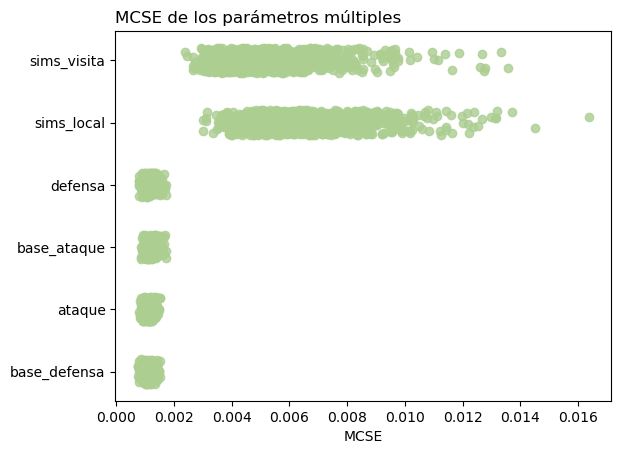

In [14]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color=config['visuals']['colors']['verde']
    ,alpha=0.8)

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(diagnostico)
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    ,labels=vis_.param.cat.categories)

plt.show()

### 2.2.2 Número efectivo de simulaciones

Primero se observa el `N_Eff` de lo parámetros únicos

In [15]:
# Datos de visualización
diagnostico = 'N_Eff'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

,param,N_Eff
0,lp__,10167.5
1,boost_local,39833.0
2,intercepto,23517.4
3,sigma_ataque,13543.3
4,sigma_defensa,23414.5


Visualización del error estándar MC de los parámetros múltiples

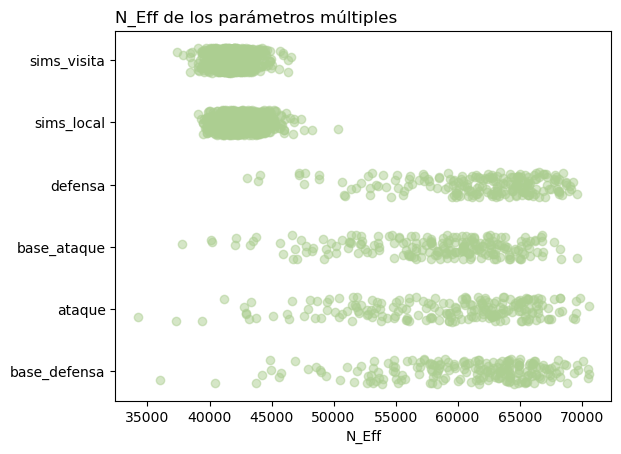

In [16]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color=config['visuals']['colors']['verde']
    ,alpha=0.5)

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(diagnostico)
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    ,labels=vis_.param.cat.categories)

plt.show()

### 2.2.3 Factor de reducción de escala

Primero se observa el `R_hat` de lo parámetros únicos

In [17]:
# Datos de visualización
diagnostico = 'R_hat'
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() == 1].keys()

(
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

,param,R_hat
0,lp__,1.00061
1,boost_local,1.00008
2,intercepto,1.00024
3,sigma_ataque,1.00044
4,sigma_defensa,1.00012


Visualización del error estándar MC de los parámetros múltiples

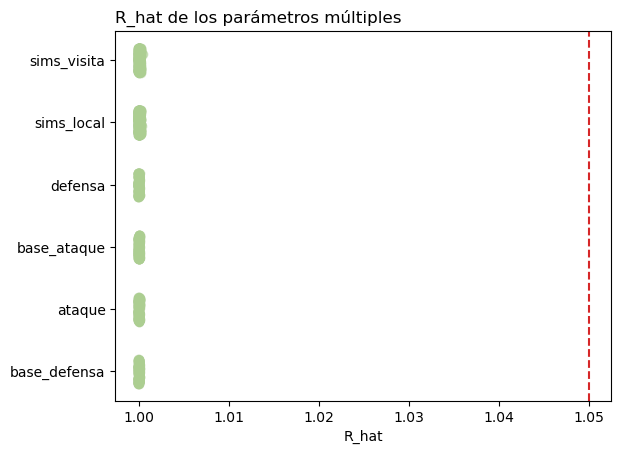

In [18]:
# Datos de visualización
mask_ = summary_vis_.param.value_counts()[summary_vis_.param.value_counts() > 1].keys()
vis_ = (
    summary_vis_
    .loc[summary_vis_.param.isin(mask_)]
    .filter(items=['param', diagnostico])
    .assign(
        param = lambda df_: pd.Categorical(df_.param)
    )
)

# Especificaciones de figuras
fig, ax = plt.subplots()

# Visualizaciones
ax.scatter(
    x=vis_[diagnostico]
    ,y=vis_.param.cat.codes + np.random.uniform(low=-0.2, high=0.2, size=vis_.shape[0])
    ,color=config['visuals']['colors']['verde']
    ,alpha=0.5)
ax.axvline(x=1.05, color='tab:red', linestyle='--')

# Anotaciones y estilo
ax.set_title(f'{diagnostico} de los parámetros múltiples', loc='left')
ax.set_xlabel(diagnostico)
ax.set_yticks(
    ticks=vis_.param.cat.codes.unique()
    ,labels=vis_.param.cat.categories)

plt.show()

### 2.2.4 Traza de las cadenas

In [19]:
chains_ = fit_.draws(inc_warmup=False, concat_chains=False)
chains_.shape

(5000, 8, 2557)

Parámetros simples

In [20]:
def traceplot_single_param(param, type):
    idp_ = fit_.column_names.index(param)
    arr_ = chains_[:, :, idp_]

    # Especificaciones de figura
    plt.figure(figsize=(10,5))

    if type == 'traceplot':
        # Visualizaciones
        for chain in range(arr_.shape[1]):
            plt.plot(
                arr_[:, chain]
                ,color=list(config['visuals']['colors'].values())[chain]
                ,label=f'Chain: {chain}')

        # Anotaciones y estilo
        plt.title(f'Traza de las cadenas, {param}', loc='left')
        plt.xlabel('Iteraciones')
        plt.ylabel('Espacio parametral')
        plt.legend()

    if type == 'convergence':
        ergo_ = np.apply_along_axis(func1d=lambda x: x.cumsum(), axis=0, arr=arr_)
        ergo_ = ergo_ / np.arange(1, ergo_.shape[0]+1, 1).reshape((-1,1))

        # Visualizaciones
        for chain in range(ergo_.shape[1]):
            plt.plot(
                ergo_[:, chain]
                ,color=list(config['visuals']['colors'].values())[chain]
                ,label=f'Chain: {chain}')

        # Anotaciones y estilo
        plt.title(f'Promedios ergódicos, {param}', loc='left')
        plt.xlabel('Iteraciones')
        plt.ylabel('Espacio parametral')
        plt.legend()

    plt.show()

In [21]:
widgets.interact(
    traceplot_single_param
    ,param=widgets.Dropdown(
        options=single_params
        ,description='Param'
        ,disabled=False)
    ,type=widgets.Dropdown(
        options=['traceplot','convergence']
        ,description='Type'
        ,disabled=False)
        
)

interactive(children=(Dropdown(description='Param', options=('lp__', 'boost_local', 'intercepto', 'sigma_ataqu…

<function __main__.traceplot_single_param(param, type)>

In [22]:
preds = {
    'preds_home':(
        summary_vis_
        .loc[summary_vis_.param == 'sims_local']
        .Mean
        .apply(int)).values
    ,'preds_away':(
    summary_vis_
    .loc[summary_vis_.param == 'sims_visita']
    .Mean
    .apply(int)).values
}

preds = (
    pd.DataFrame(preds)
    .assign(
        # -1: Away win, 0: Draw, 1: Home win
        result = lambda df_:
            (df_.preds_home - df_.preds_away).apply(np.sign)
    )
)
preds

,preds_home,preds_away,result
0,1,1,0
1,0,3,-1
2,1,0,1
3,1,1,0
4,1,0,1
...,...,...,...
858,1,2,-1
859,1,1,0
860,1,1,0
861,2,0,1


In [23]:
# Accuracy de ganador
sum(preds.result == df_.result) / df_.shape[0]

0.6048667439165701

In [24]:
# Accuracy goals_home
sum(preds.preds_home == df_.home_team_score) / df_.shape[0]

0.39745075318655854

In [25]:
# Accuracy goals away
sum(preds.preds_away == df_.away_team_score) / df_.shape[0]

0.4646581691772885

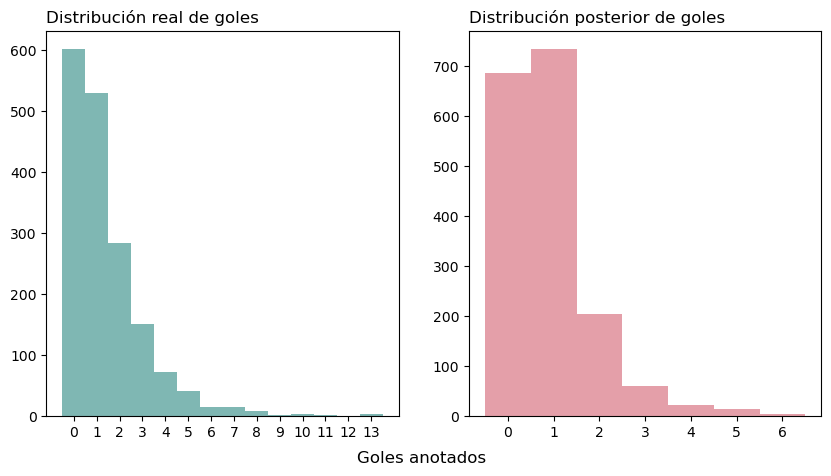

In [26]:
vis_ = pd.DataFrame(
    {'real': pd.concat((df_.home_team_score, df_.away_team_score))}
)
# Goles simulados
vis_['sims'] = pd.concat((preds.preds_home, preds.preds_away))

# Especificaciones de figura
fig = plt.figure(figsize=(10,5))
gs = plt.GridSpec(nrows=1, ncols=2, figure=fig, wspace=0.2, hspace=0.2)

# Visualizaciones
ax1 = fig.add_subplot(gs[0])
ax1.hist(
    x=vis_.real
    ,bins=vis_.real.max()
    ,align='left'
    ,color=config['visuals']['colors']['aqua']
    ,alpha=0.5)

ax2 = fig.add_subplot(gs[1])
ax2.hist(
    x=vis_.sims
    ,bins=vis_.sims.max()
    ,align='left'
    ,color=config['visuals']['colors']['rojo']
    ,alpha=0.5)

# Anotaciones y estilo
ax1.set_title('Distribución real de goles', loc='left')
ax1.set_xticks(np.arange(vis_.real.min(),vis_.real.max(),1))

ax2.set_title(f'Distribución posterior de goles', loc='left')
ax2.set_xticks(np.arange(vis_.sims.min(),vis_.sims.max(),1))
fig.supxlabel('Goles anotados')

plt.savefig(name+'sims_post.png', bbox_inches='tight')

plt.show()